## Bibliotecas e GPU

In [1]:
# Bibliotecas
import os
import random
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

from funcs import modificacoes, banco, tvt
from redes.unet import unet 
from redes.ResUnet import MultiResUnet


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping


2026-02-26 21:01:32.204745: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-26 21:01:32.213829: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-26 21:01:32.659132: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-26 21:01:35.566085: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [2]:
# Configuração (GPU / mixed precision / strategy)

print('TensorFlow:', tf.__version__)
print('Built with CUDA:', tf.test.is_built_with_cuda())

gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')
print('GPUs:', gpus)
print('CPUs:', cpus)

# Importante: fazer isso ANTES de criar modelos/estratégias, para evitar reservar toda a VRAM
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception as e:
            print('Não foi possível habilitar memory growth:', e)

    # Mixed precision costuma reduzir MUITO o uso de VRAM em U-Net
    mixed_precision.set_global_policy('mixed_float16')
    print('Mixed precision policy:', mixed_precision.global_policy())

# Estratégia: só use MirroredStrategy se tiver >1 GPU
strategy = tf.distribute.MirroredStrategy() if len(gpus) > 1 else tf.distribute.get_strategy()
print('Strategy:', type(strategy).__name__)

TensorFlow: 2.20.0
Built with CUDA: True
GPUs: []
CPUs: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Strategy: _DefaultDistributionStrategy


E0000 00:00:1772150499.952105    8125 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1772150499.970068    8125 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# Mais detalhes de GPU
# Se quiser ver detalhes, rode este bloco.
gpus = tf.config.list_physical_devices('GPU')
for i, g in enumerate(gpus):
    try:
        details = tf.config.experimental.get_device_details(g)
    except Exception as e:
        details = {'error': str(e)}
    print(f'GPU {i}:', g, 'details:', details)

## Montando o Banco de dados

In [4]:
""" Divide e modifica o banco de dados"""
# x_train
path_x_train = 'banco2/TreinoGeral/imgs/'
path_x_train_modificacoes = 'banco2/TreinoGeral/imgs_AUGMENTATION'
# path_x_train_modificacoes = 'banco2/Nelore1/imgAUGMENTATION'


# Função para fazer as modificações nas imagens
# modificacoes(path_x_train, 
#              path_x_train_modificacoes, 
#              original = True, 
#              brilho = 1.5,  
#              flip = False, 
#              escura = 0.5, 
#              rotacao=None)

# Função para carregar o banco de imagens
x_train = banco(path_x_train_modificacoes, resolution=(256,256), grayscale= True)

# y_train
path_y_train = 'banco2/TreinoGeral/label/'
path_y_train_modificacoes = 'banco2/TreinoGeral/label_AUGMENTATION'
# path_y_train_modificacoes = 'banco2/Nelore1/labelAUGMENTATION'



lista_img_train = os.listdir(path_x_train_modificacoes)
lista_img_label = os.listdir(path_y_train)

# duplica imagens de label se necessario
# for i,nome_arquivo in enumerate(lista_img_label):
#     for j,nome_arquivo_train in enumerate(lista_img_train):
#         if nome_arquivo[:6] == nome_arquivo_train[:6]:
#             caminho = os.path.join(path_y_train, nome_arquivo)
#             img = cv2.imread(caminho)
#             novo_nome = lista_img_train[j] +f'_{j}.png'
#             destino = os.path.join(path_y_train_modificacoes, novo_nome)
#             cv2.imwrite(destino, img)
#             print(f'A imagem {nome_arquivo} foi duplicada para igualar quantidade.')

y_train, labels = banco(path_y_train_modificacoes, resolution=(256,256), grayscale= True, nomes=True)


In [5]:
# Prints de verificação
print(f'Imagens : {x_train.shape}')
print(f'Máscaras: {y_train.shape}')
print(f'Labels  : {set(labels[0:3])}')
# print(f'label: {labels[2][2:6]}')

Imagens : (378, 256, 256, 1)
Máscaras: (378, 256, 256, 1)
Labels  : {'I-2519-251119-162630_origi_0.jpg_2.png', 'I-2519-251119-162630_dark_0.jpg_0.png', 'I-2519-251119-162630_luz_0.jpg_1.png'}


In [6]:
""" Visualizando algumas imagens e labels """
def plot_img_mask(img_list, mask_list, num_pairs = 5, label = None):
    n = num_pairs
    plt.figure(figsize=(10, 6))
    for i in range(n):
        idx = random.randint(0, len(img_list) - 1)
        img = img_list[idx]
        mask = mask_list[idx]
        plt.subplot(2, n, i + 1)
        plt.imshow(img)
        if label is not None and len(label) > idx:
            plt.title(f"Imagem = {label[idx][2:6]}, index =  {idx}", fontsize=9)
        plt.axis("off")

        plt.subplot(2, n, i + 1 + n)
        plt.imshow(mask)
        if label is not None and len(label) > idx:
            plt.title(f"Label = {label[idx][2:6]}, index = {idx}", fontsize=9)
        plt.axis("off")
        del img, mask

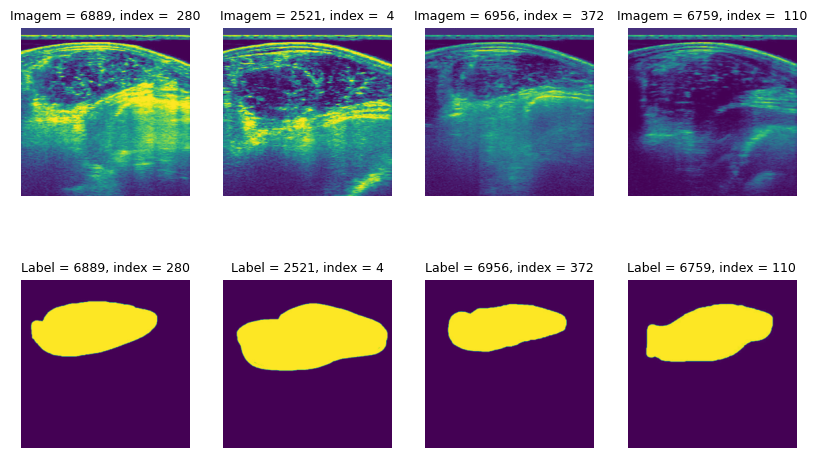

In [7]:
# Plot da função
plot_img_mask(x_train, y_train, num_pairs= 4, label= labels)

In [8]:
""" Função tvt: train, val, test """
x_train, y_train, nomes_train, x_val, y_val, nomes_val, x_test, y_test, nomes_test = tvt(x_train, y_train, partition=(0.6, 0.2, 0.2), nomes = labels) # 70% treino, 10% validação, 20% teste

In [9]:
# Prints de verificação dos conjuntos
print(f'Imagens X treino: {x_train.shape}')
print(f'Imagens Y treino: {y_train.shape}')
print(f'Nomes treino: {len(nomes_train)}')

print(f'Imagens X teste: {x_test.shape}')
print(f'Imagens Y teste: {y_test.shape}')
print(f'Nomes teste: {len(nomes_test)}')

print(f'Imagens X validação: {x_val.shape}')
print(f'Imagens Y validação: {y_val.shape}')
print(f'Nomes validação: {len(nomes_val)}')

Imagens X treino: (226, 256, 256, 1)
Imagens Y treino: (226, 256, 256, 1)
Nomes treino: 226
Imagens X teste: (77, 256, 256, 1)
Imagens Y teste: (77, 256, 256, 1)
Nomes teste: 77
Imagens X validação: (75, 256, 256, 1)
Imagens Y validação: (75, 256, 256, 1)
Nomes validação: 75


Treino
Validação
Teste


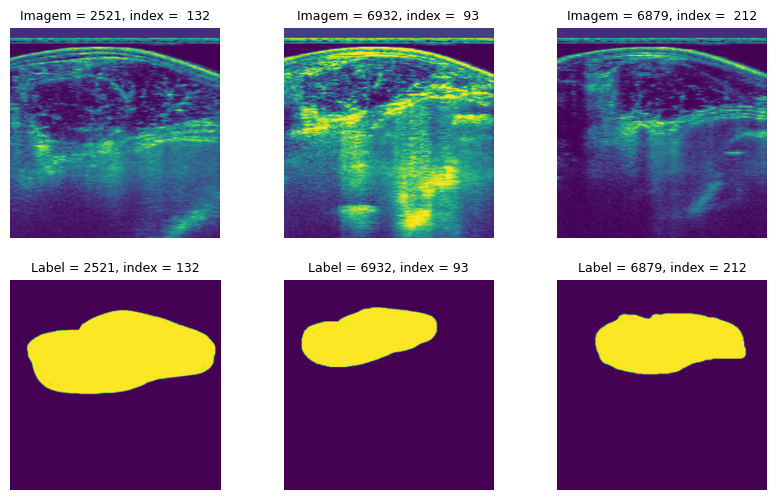

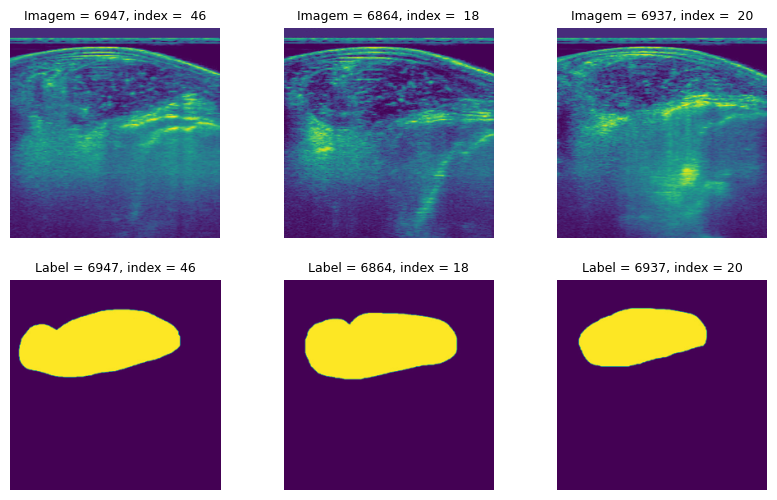

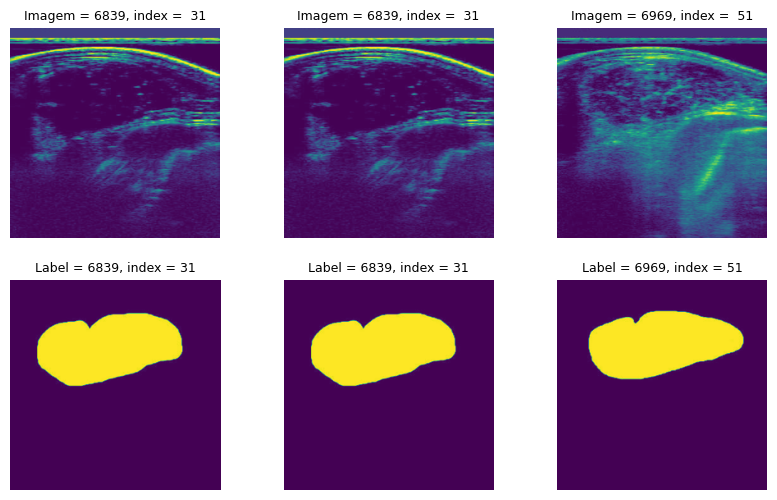

In [10]:
print("Treino")
plot_img_mask(x_train, y_train, num_pairs= 3, label= nomes_train)
print("Validação")
plot_img_mask(x_val, y_val, num_pairs= 3, label= nomes_val)
print("Teste")
plot_img_mask(x_test, y_test, num_pairs= 3, label= nomes_test)

## Modelos e métricas

In [11]:
# Converting the arrays into tf.data batches (mais leve e eficiente)
AUTOTUNE = tf.data.AUTOTUNE

# Se ainda der OOM, o 1º ajuste é reduzir batch_size
batch_size = 1

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.shuffle(buffer_size=len(x_train), seed=42, reshuffle_each_iteration=True)
train_data = train_data.batch(batch_size).prefetch(AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(batch_size).prefetch(AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(batch_size).prefetch(AUTOTUNE)

In [12]:
""" setting DICE coefficient to evaluate the model """
def dice_coefficient(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Flatten per-sample to compute Dice over all pixels
    y_true_f = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
    y_pred_f = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)
    union = tf.reduce_sum(y_true_f, axis=1) + tf.reduce_sum(y_pred_f, axis=1)
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
    return dice_coeff

In [13]:
""" ResUnet """

with strategy.scope():
    resunet = MultiResUnet(256,256,1)
    resunet.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', dice_coefficient] 
    )

resunet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │         72 │ input_layer[0][0] │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         24 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │      1,224 │ activation[0][0]  │
│                     │ 17)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         51 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 17)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 17)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │      3,978 │ activation_1[0][… │
│                     │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         78 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │         51 │ input_layer[0][0] │
│                     │ 51)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ activation[0][0], │
│ (Concatenate)       │ 51)               │            │ activation_1[0][… │
│                     │                   │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        153 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 51)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        153 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 51)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 51)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256, 256,  │          0 │ add[0][0]         │
│ (Activation)        │ 51)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,260,063 (27.69 MB)

 Trainable params: 7,235,541 (27.60 MB)

 Non-trainable params: 24,522 (95.79 KB)

In [14]:
""" U-net """
tf.keras.backend.clear_session()

# Garante que o modelo segue o shape real dos dados
input_shape = tuple(x_train.shape[1:])  # (H, W, C)

with strategy.scope():
    # Modelo menor para caber na GPU (tente 32; se ainda der OOM, use 16)
    unet = unet(input_shape=input_shape, base_filters=64, max_filters=512)
    unet.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', dice_coefficient],
    )
unet.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 27,548,993 (105.09 MB)

 Trainable params: 27,548,993 (105.09 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
""" Defining early stopping callback """
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

## Treinamento Unet/ResUnet

In [ ]:
""" Treinando ResUnet """
resunet_history = resunet.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    callbacks=[early_stopping]
)

resunet.save('modelos/resunet_model.keras')

In [17]:
""" Treinando Unet """
unet_history = unet.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    callbacks=[early_stopping],
)

# Save the model
unet.save('modelos/unet_model_512_menosBanco.keras')

Epoch 1/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 116s 500ms/step - accuracy: 0.8081 - dice_coefficient: 0.2061 - loss: 0.4858 - val_accuracy: 0.8084 - val_dice_coefficient: 0.2104 - val_loss: 0.4258
Epoch 2/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 112s 498ms/step - accuracy: 0.8241 - dice_coefficient: 0.3106 - loss: 0.3865 - val_accuracy: 0.9286 - val_dice_coefficient: 0.7089 - val_loss: 0.1645
Epoch 3/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 113s 501ms/step - accuracy: 0.9273 - dice_coefficient: 0.7470 - loss: 0.1553 - val_accuracy: 0.9273 - val_dice_coefficient: 0.8022 - val_loss: 0.1513
Epoch 4/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 113s 499ms/step - accuracy: 0.9326 - dice_coefficient: 0.7781 - loss: 0.1353 - val_accuracy: 0.9362 - val_dice_coefficient: 0.7868 - val_loss: 0.1254
Epoch 5/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 114s 505ms/step - accuracy: 0.9370 - dice_coefficient: 0.8070 - loss: 0.1146 - val_accuracy: 0.9404 - val_dice_coefficient: 0.8160 - val_loss: 0.1094
Epoch 6/50
226/226 ━━━━━━━━━━━━━━━━━━━━ 114s 505ms

NameError: name 'unet_history' is not defined

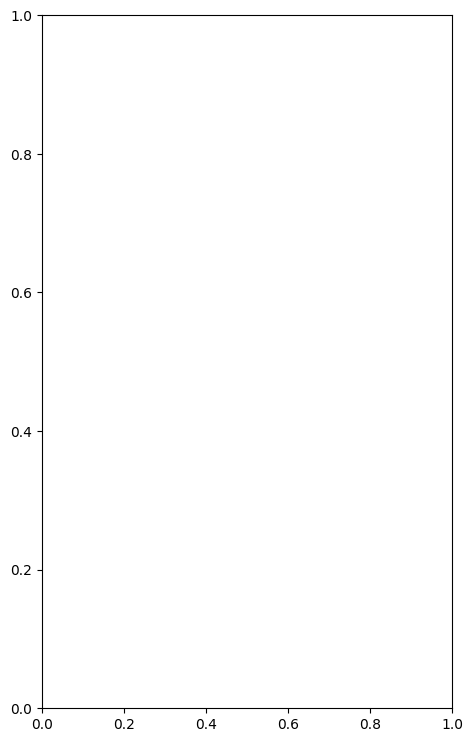

In [29]:
""" plotting the loss and accuracy during training and validation """
plt.figure(figsize=(18, 9))
plt.subplot(1, 3, 1)
plt.plot(unet_history.history['loss'])
plt.plot(unet_history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.subplot(1, 3, 2)
plt.plot(unet_history.history['accuracy'])
plt.plot(unet_history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.subplot(1, 3, 3)
plt.plot(unet_history.history['dice_coefficient'])
plt.plot(unet_history.history['val_dice_coefficient'])
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Training vs Validation Dice Coefficient')
plt.legend(['Train Dice', 'Validation Dice'])


## Carregando modelo

In [16]:
""" Carregando o modelo salvo """
modelo = keras.models.load_model('modelos/unet_model_512_menosBanco.keras', custom_objects={'dice_coefficient': dice_coefficient})
modelo.evaluate(val_data, verbose= 1)

75/75 ━━━━━━━━━━━━━━━━━━━━ 54s 698ms/step - accuracy: 0.9648 - dice_coefficient: 0.9540 - loss: 0.0336


[0.033602096140384674, 0.9647560715675354, 0.9540409445762634]

## Testando o modelo com os dados de X_val

In [17]:
""" Função: calcular área (predição vs máscara) na dimensão original (403x333) """
def comparar_area_predicao(
    idx,
    model,
    x_imgs,
    y_masks,
    nomes_dados = None,
    orig_size=(403, 333),
    threshold=0.5,
    px_per_cm=24.05,
    smooth=1e-6,
    plot=False,
    overlay_alpha=0.35,
    contours=True,
    verbose=True,
 ):
    """
    Compara a área da predição com a máscara verdadeira na dimensão original.

    Observação: se x_imgs/y_masks estiverem em 256x256 (por causa do pre-processamento),
    a comparação em 403x333 é feita via resize NEAREST para manter máscara binária.

    Retorna um dicionário com áreas (px² e cm²), diferença e métricas (Dice/IoU).
    """
    orig_h, orig_w = orig_size  # (H, W)
    cm2_per_px2 = 1.0 / (px_per_cm ** 2)
    # Pega amostra
    x = x_imgs[idx]
    y_true = y_masks[idx]
    # Predição (probabilidade)
    x_in = tf.expand_dims(x, axis=0)
    y_pred = model.predict(x_in, verbose=0)
    y_pred = np.squeeze(y_pred)
    # Binariza
    y_pred_bin = (y_pred >= threshold).astype(np.uint8)
    y_true = np.squeeze(y_true)
    # Se a máscara veio como 0..255, normaliza implicitamente via threshold
    y_true_bin = (y_true >= threshold).astype(np.uint8)
    # Garante 2D
    if y_pred_bin.ndim == 3:
        y_pred_bin = np.squeeze(y_pred_bin)
    if y_true_bin.ndim == 3:
        y_true_bin = np.squeeze(y_true_bin)
    # Resize para dimensão original (OpenCV usa (W,H))
    pred_orig = cv2.resize(y_pred_bin, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST_EXACT)
    true_orig = cv2.resize(y_true_bin, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST_EXACT)
    # Áreas (px²) e (cm²)
    area_pred_px = int(pred_orig.sum())
    area_true_px = int(true_orig.sum())
    area_pred_cm2 = area_pred_px * cm2_per_px2
    area_true_cm2 = area_true_px * cm2_per_px2
    diff_px = area_pred_px - area_true_px
    diff_cm2 = diff_px * cm2_per_px2
    perc_diff = (100.0 * diff_px / area_true_px) if area_true_px > 0 else np.nan
    # Métricas na dimensão original
    intersection = int((pred_orig & true_orig).sum())
    union = int((pred_orig | true_orig).sum())
    dice = (2.0 * intersection + smooth) / (area_pred_px + area_true_px + smooth)
    iou = (intersection + smooth) / (union + smooth)
    result = {
        'idx': idx,
        'orig_size': (orig_h, orig_w),
        'threshold': float(threshold),
        'px_per_cm': float(px_per_cm),
        'area_pred_px2': area_pred_px,
        'area_true_px2': area_true_px,
        'area_pred_cm2': float(area_pred_cm2),
        'area_true_cm2': float(area_true_cm2),
        'diff_px2': int(diff_px),
        'diff_cm2': float(diff_cm2),
        'perc_diff_%': float(perc_diff) if not np.isnan(perc_diff) else np.nan,
        'dice_orig': float(dice),
        'iou_orig': float(iou),
    }
    if verbose:
        print(
            f"idx={idx} | area_true={area_true_cm2:.3f} cm² | "
            f"area_pred={area_pred_cm2:.3f} cm² | diff={np.abs(diff_cm2):+.3f} cm² | "
            f"dice={dice:.4f} | iou={iou:.4f}"
        )
    if plot:
        img = np.squeeze(x)
        # Mostra na dimensão do modelo (p/ referência) e overlays na dimensão original
        plt.figure(figsize=(14, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        if nomes_dados is not None and len(nomes_dados) > idx:
            plt.title(f'Imagem (modelo) idx={idx} | {nomes_dados[idx][2:6]}')
        else:
            plt.title(f'Imagem (modelo) idx={idx}')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(true_orig, cmap='gray')
        plt.title(f'Máscara verdadeira (orig {orig_h}x{orig_w})')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(pred_orig, cmap='gray')
        plt.title(f'Máscara predita (orig {orig_h}x{orig_w})')
        plt.axis('off')
        plt.show()
        # Overlay (opcional)
        plt.figure(figsize=(7, 7))
        plt.imshow(cv2.resize(img, (orig_w, orig_h), interpolation=cv2.INTER_LINEAR), cmap='gray') # Plano de fundo
        plt.imshow(true_orig, cmap='Reds', alpha=overlay_alpha, vmin=0, vmax=1)
        plt.imshow(pred_orig, cmap='Blues', alpha=overlay_alpha, vmin=0, vmax=1)
        if contours:
            try:
                plt.contour(true_orig, levels=[0.5], colors='red', linewidths=1)
                plt.contour(pred_orig, levels=[0.5], colors='deepskyblue', linewidths=1)
            except Exception:
                pass
        plt.title(f'Overlay (orig) idx={idx} | true=vermelho | pred=azul')
        plt.axis('off')
        plt.show()
    return result

idx=0 | area_true=44.390 cm² | area_pred=42.403 cm² | diff=+1.987 cm² | dice=0.9703 | iou=0.9422


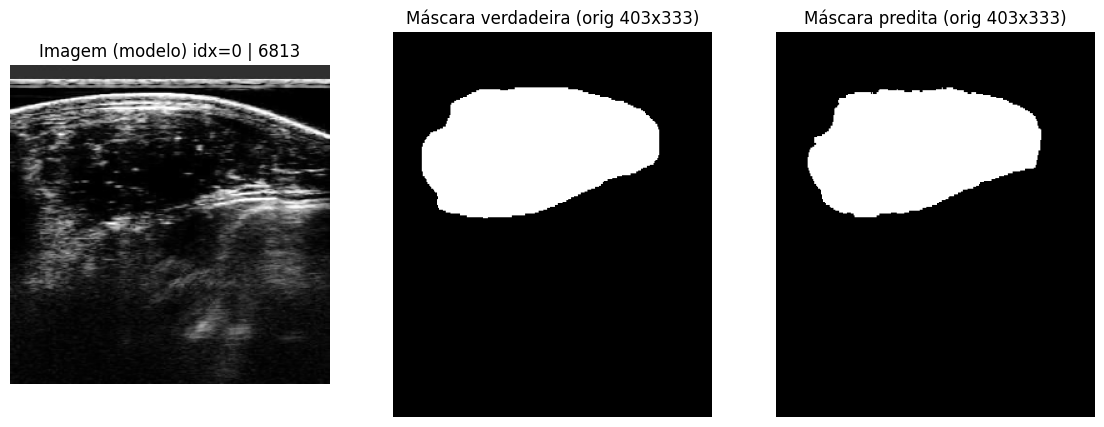

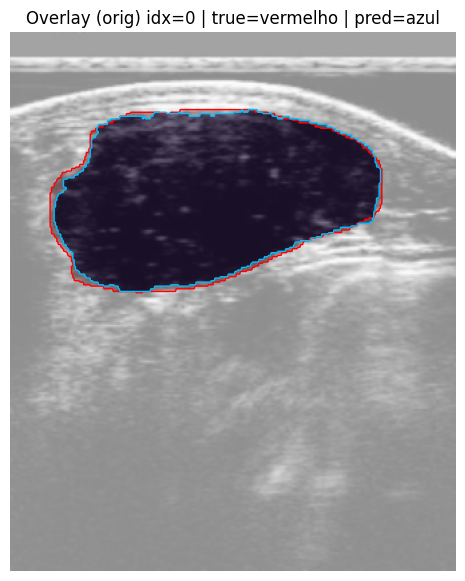

idx=1 | area_true=48.893 cm² | area_pred=47.080 cm² | diff=+1.814 cm² | dice=0.9791 | iou=0.9591


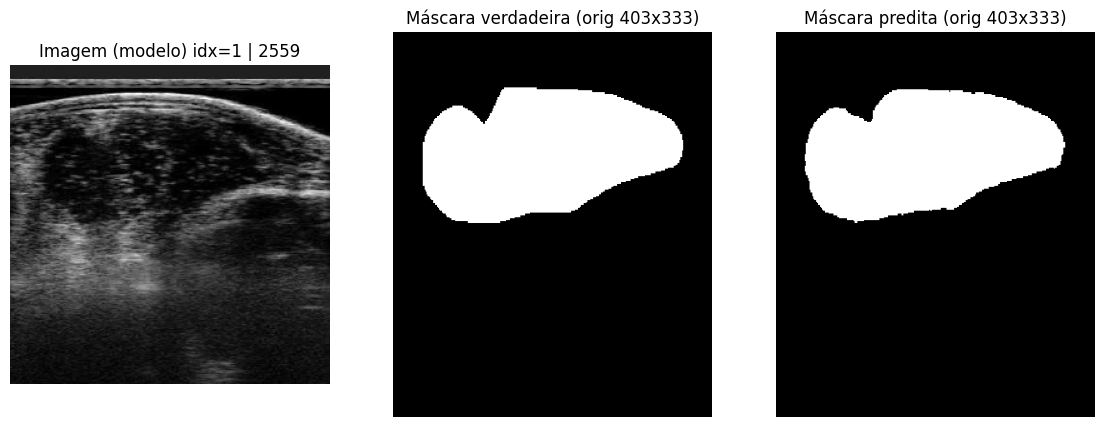

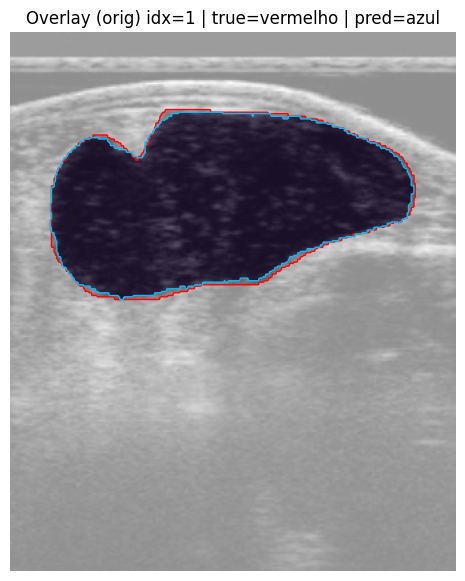

idx=2 | area_true=32.158 cm² | area_pred=31.291 cm² | diff=+0.866 cm² | dice=0.9735 | iou=0.9483


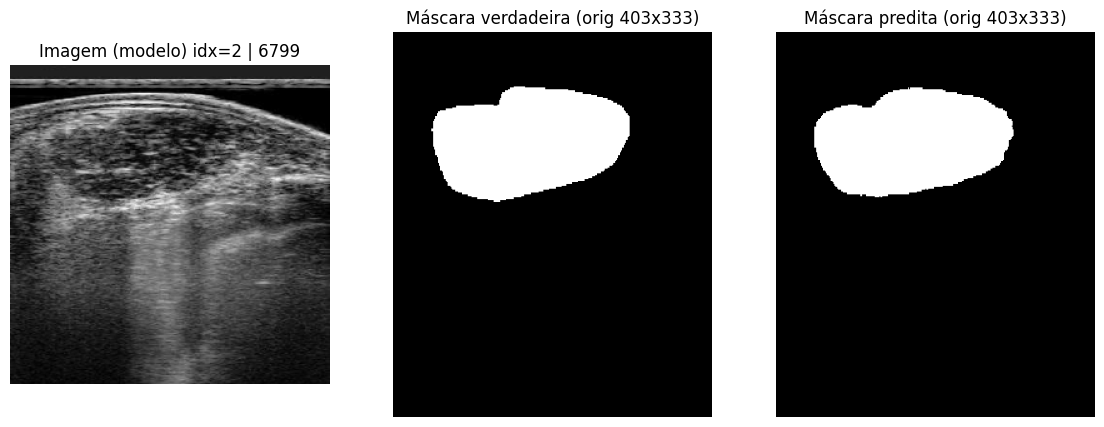

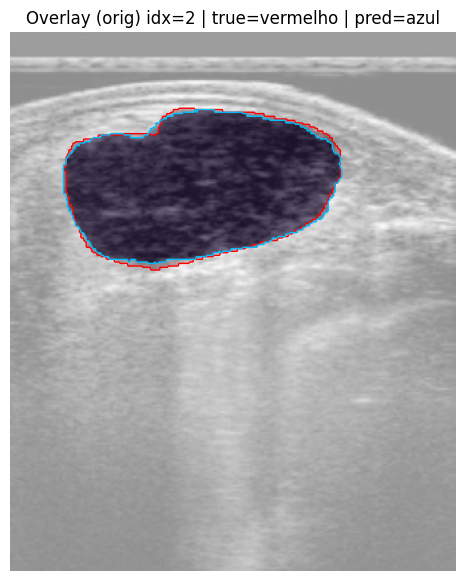

idx=3 | area_true=40.527 cm² | area_pred=39.747 cm² | diff=+0.780 cm² | dice=0.9794 | iou=0.9597


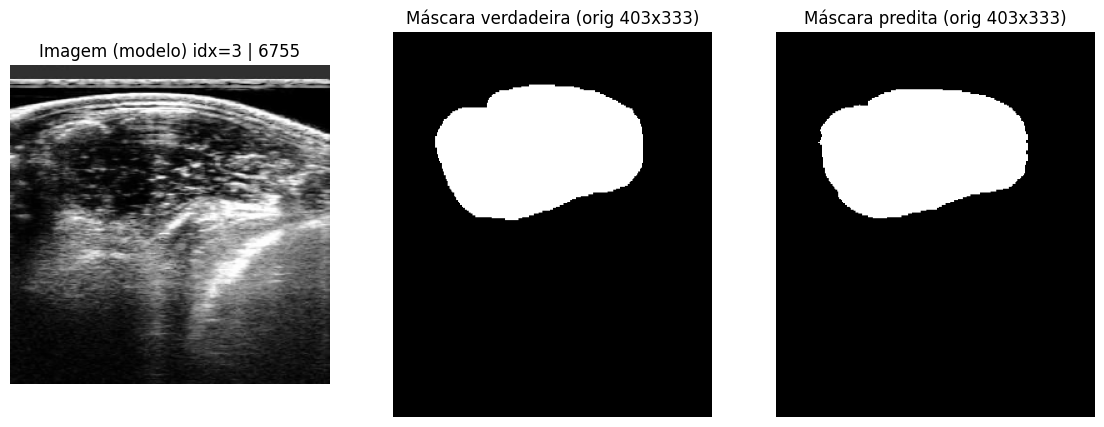

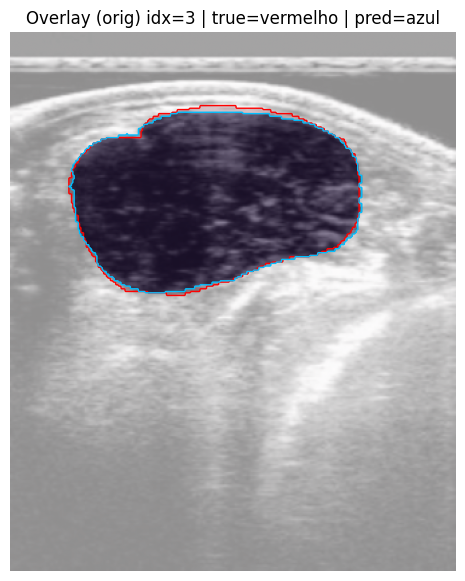

idx=4 | area_true=50.252 cm² | area_pred=49.106 cm² | diff=+1.146 cm² | dice=0.9799 | iou=0.9606


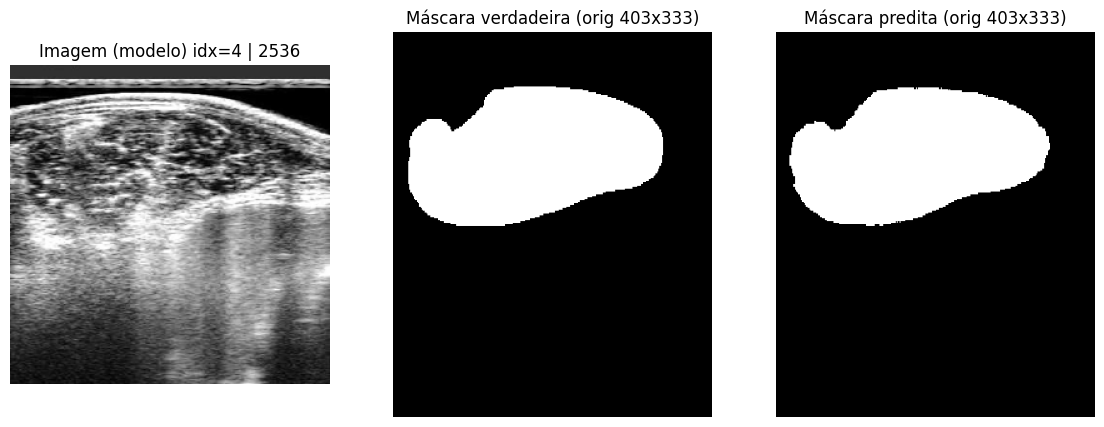

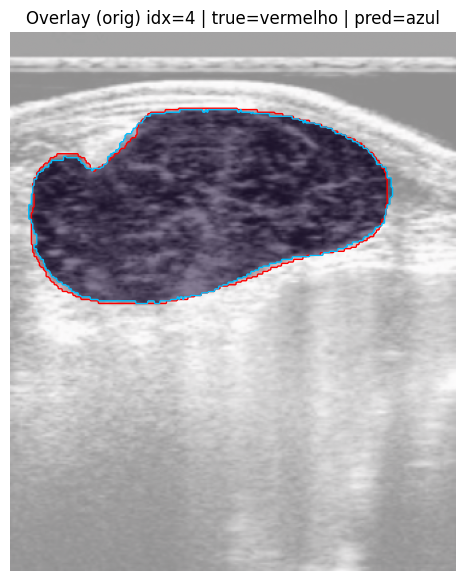

In [19]:
# Print função área
for idx in range(5):
    comparar_area_predicao(
        idx,
        modelo,
        x_val,
        y_val,
        nomes_dados= nomes_val,
        orig_size=(403, 333),
        threshold=0.5,
        px_per_cm=24.05,
        smooth=1e-6,
        plot=True,
        overlay_alpha=0.35,
        contours=True,
        verbose=True,
    )

In [20]:
""" Calculando a média dos erros"""
erros = []
area_real: list[float] = [] 
area_predita: list[float] = []
for idx in range(len(x_val)):
    resultado = comparar_area_predicao(
        idx,
        modelo,
        x_val,
        y_val,
        nomes_dados= nomes_val,
        orig_size=(403, 333),
        threshold=0.5,
        px_per_cm=24.05,
        smooth=1e-6,
        plot=False,
        overlay_alpha=0.35,
        contours=True,
        verbose=False,
    )
    erros.append(resultado['diff_cm2'])
    area_real.append(resultado['area_true_cm2'])
    area_predita.append(resultado['area_pred_cm2'])

In [21]:
# Print dos erros
print(f'Erro médio na validação: {np.mean(np.abs(erros)):.3f} cm²')
print(f'Erro Máximo na validação: {np.max(np.abs(erros)):.3f} cm²')
print(f'Erro mínimo na validação: {np.min(np.abs(erros)):.3f} cm²')

Erro médio na validação: 1.220 cm²
Erro Máximo na validação: 8.814 cm²
Erro mínimo na validação: 0.009 cm²


In [23]:
# Print áreas
print(f' Verificando área: {area_real[2]}')
print(f' Verificando área: {area_predita[2]}')

 Verificando área: 32.15753735504255
 Verificando área: 31.29135852628576


## Testando em outras imagens

In [24]:
""" Testando outras imagens """
path_x_new = 'banco2/Validacao/imgs/'
path_y_new = 'banco2/Validacao/labels/'
x_new = banco(path_x_new, resolution=(256,256), grayscale= True)
y_new = banco(path_y_new, resolution=(256,256), grayscale= True)

print(f'Novas imagens : {x_new.shape}')
print(f'Novos rótulos : {y_new.shape}')

new_data = tf.data.Dataset.from_tensor_slices((x_new, y_new))
new_data = new_data.batch(batch_size).prefetch(AUTOTUNE)
modelo.evaluate(new_data, verbose= 1)

Novas imagens : (9, 256, 256, 1)
Novos rótulos : (9, 256, 256, 1)
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 611ms/step - accuracy: 0.9492 - dice_coefficient: 0.9062 - loss: 0.1428


[0.14277350902557373, 0.9491865634918213, 0.9062265753746033]

idx=0 | area_true=40.596 cm² | area_pred=37.263 cm² | diff=+3.333 cm² | dice=0.9242 | iou=0.8591


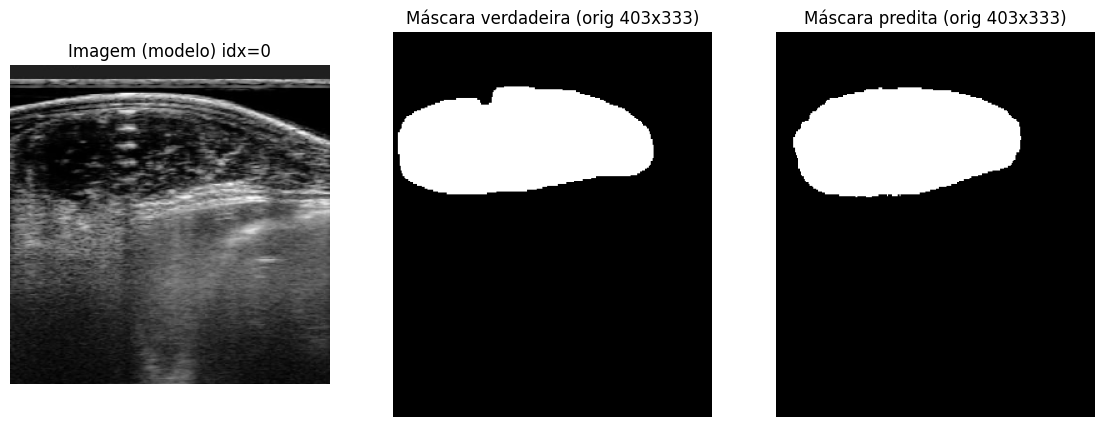

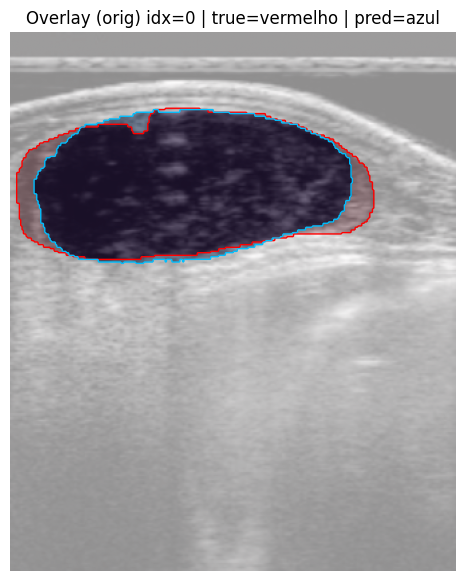

idx=1 | area_true=49.865 cm² | area_pred=43.198 cm² | diff=+6.667 cm² | dice=0.9161 | iou=0.8451


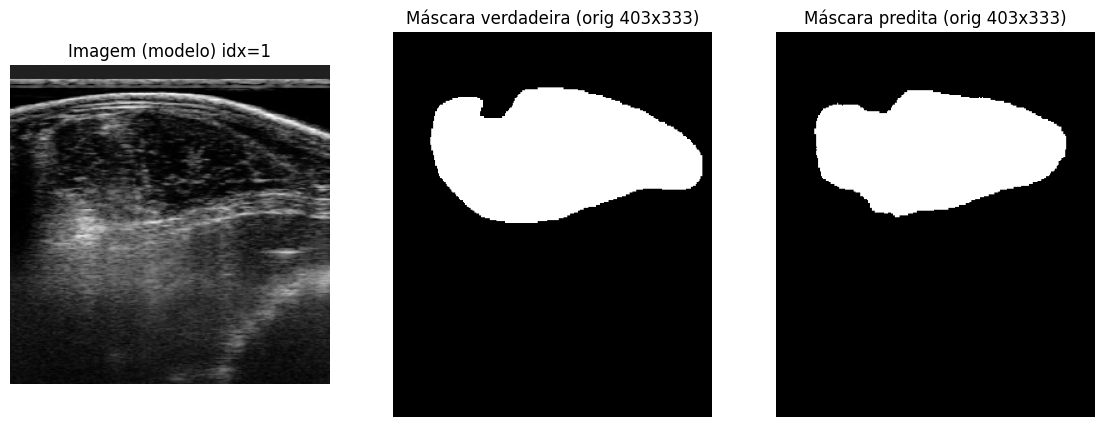

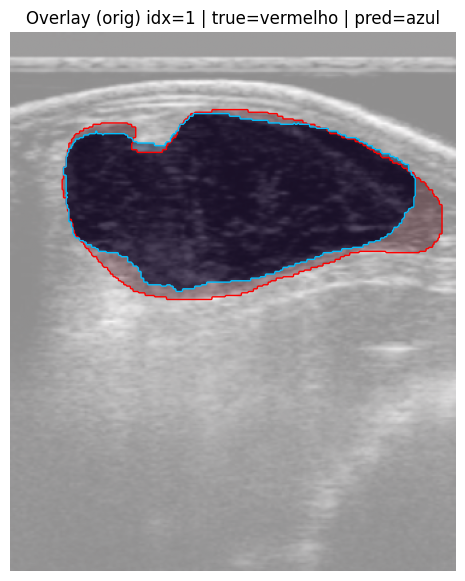

idx=2 | area_true=50.131 cm² | area_pred=46.758 cm² | diff=+3.373 cm² | dice=0.9339 | iou=0.8759


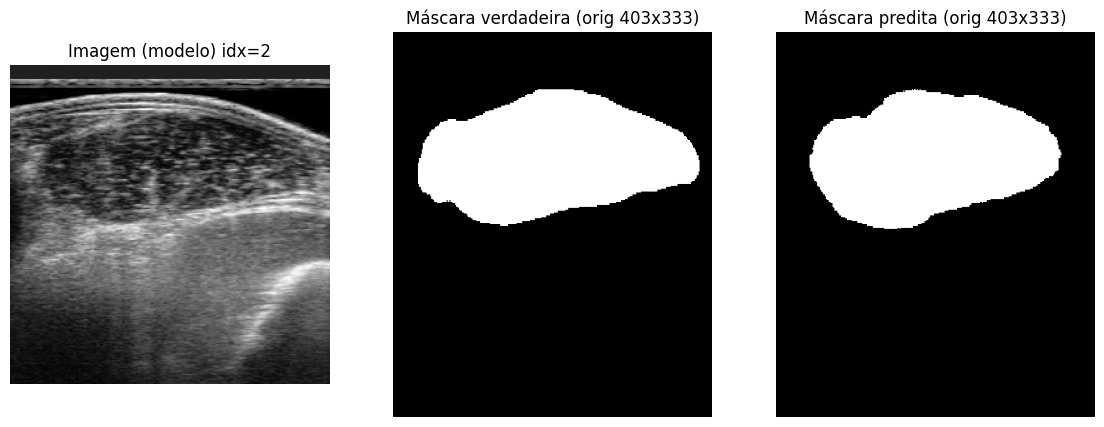

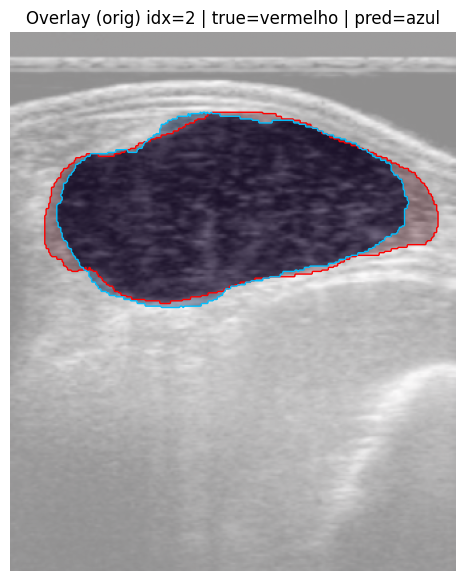

idx=3 | area_true=43.522 cm² | area_pred=41.914 cm² | diff=+1.608 cm² | dice=0.9237 | iou=0.8583


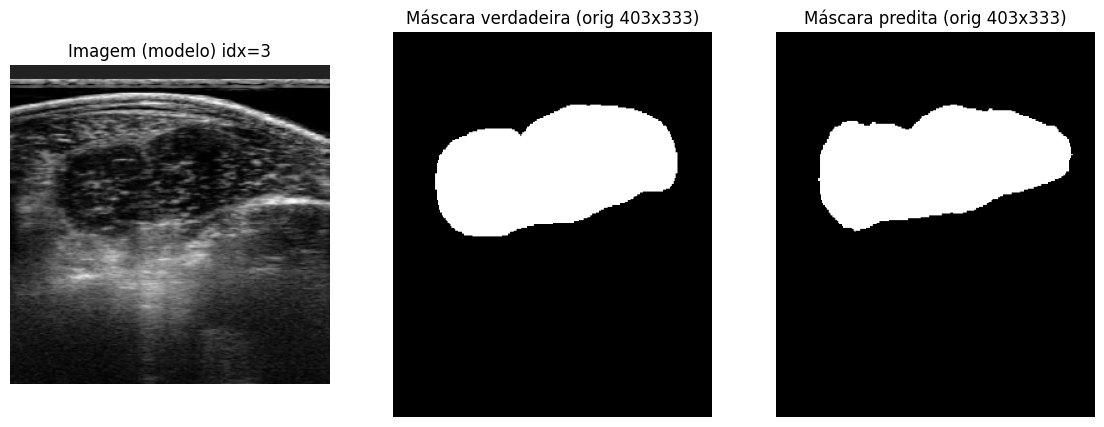

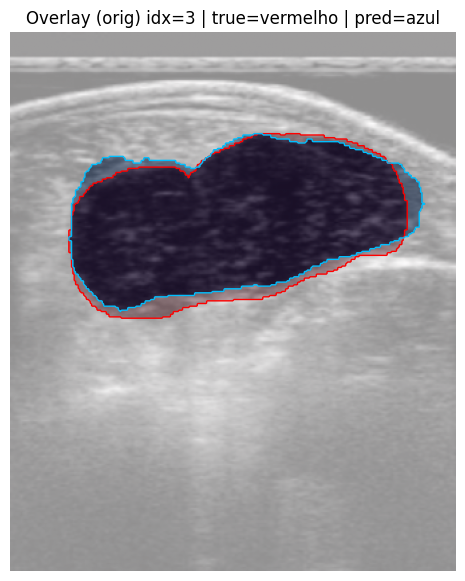

idx=4 | area_true=39.775 cm² | area_pred=39.562 cm² | diff=+0.213 cm² | dice=0.9560 | iou=0.9157


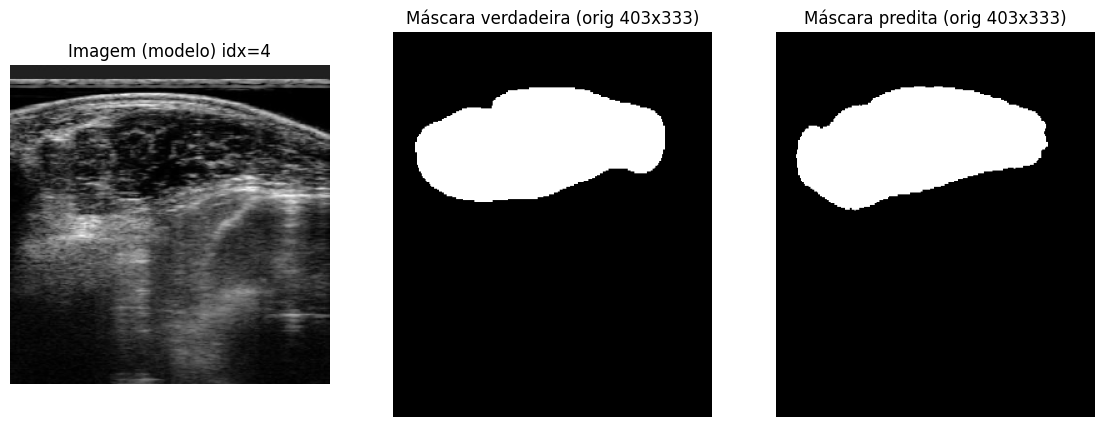

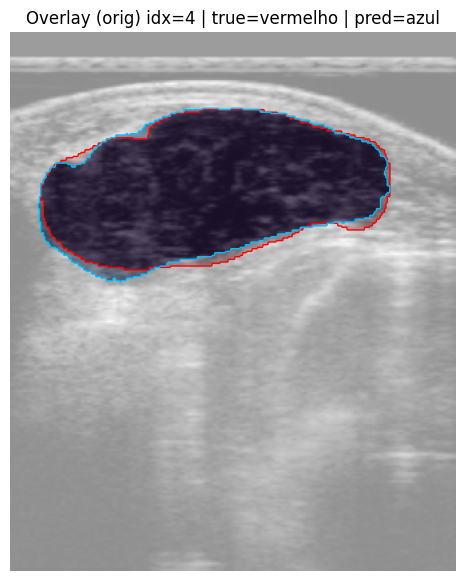

idx=5 | area_true=33.482 cm² | area_pred=37.915 cm² | diff=+4.433 cm² | dice=0.8701 | iou=0.7700


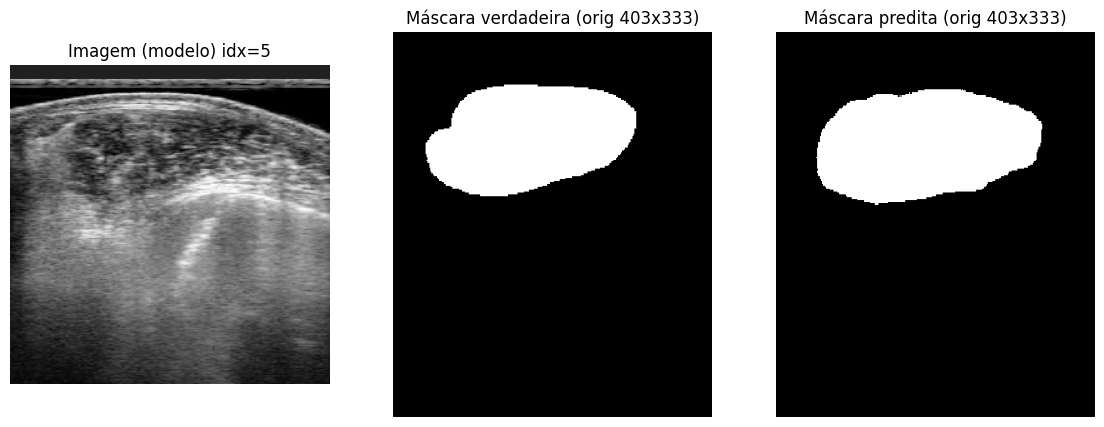

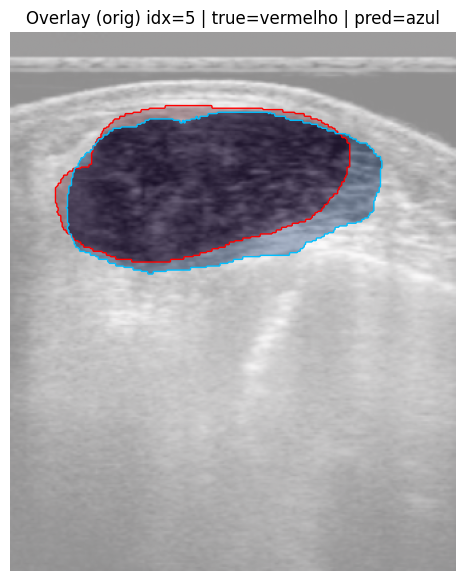

idx=6 | area_true=38.814 cm² | area_pred=48.598 cm² | diff=+9.784 cm² | dice=0.8634 | iou=0.7596


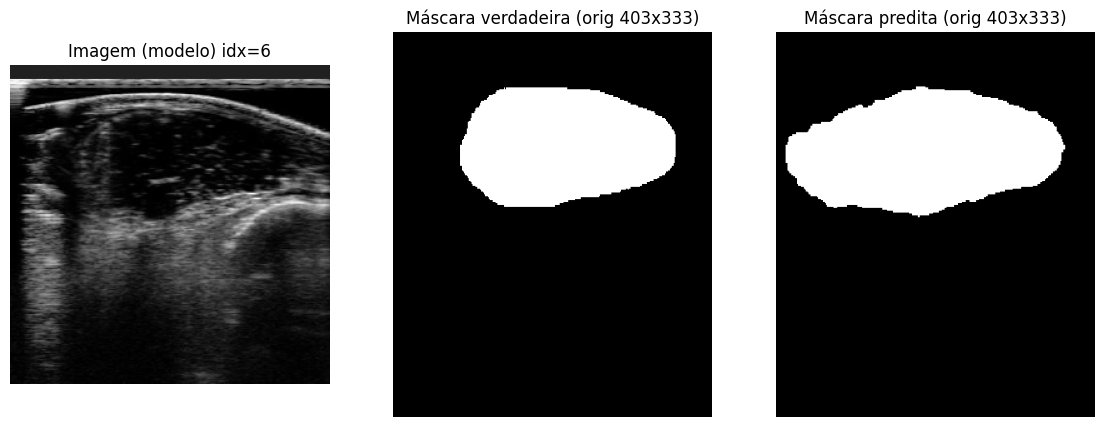

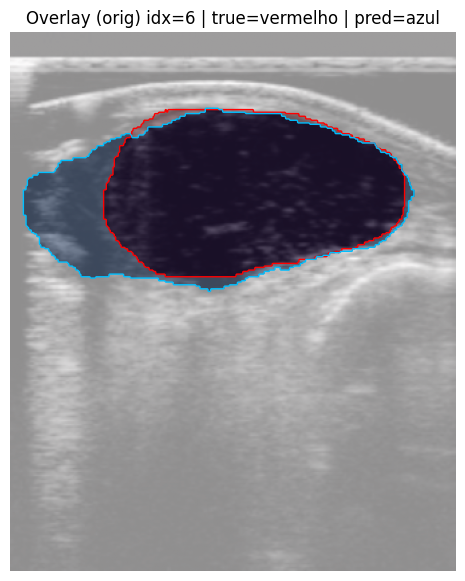

idx=7 | area_true=42.336 cm² | area_pred=44.384 cm² | diff=+2.049 cm² | dice=0.9091 | iou=0.8334


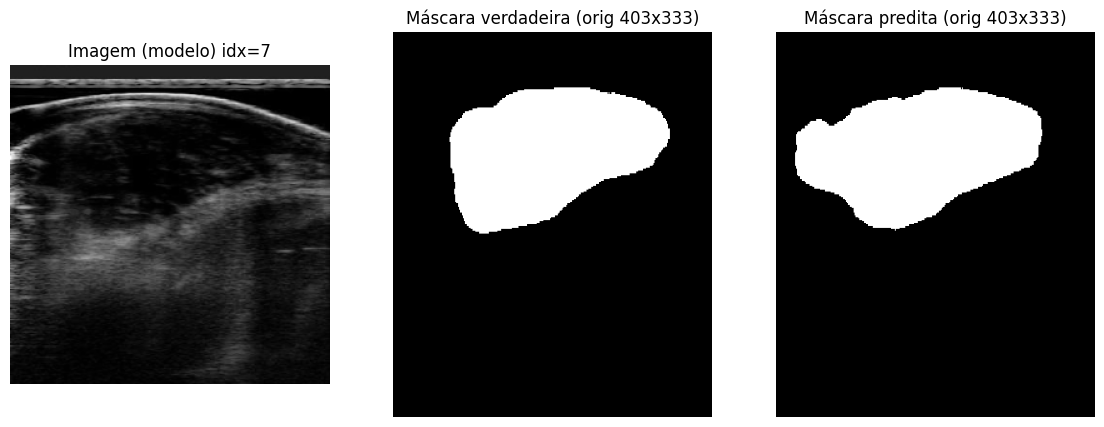

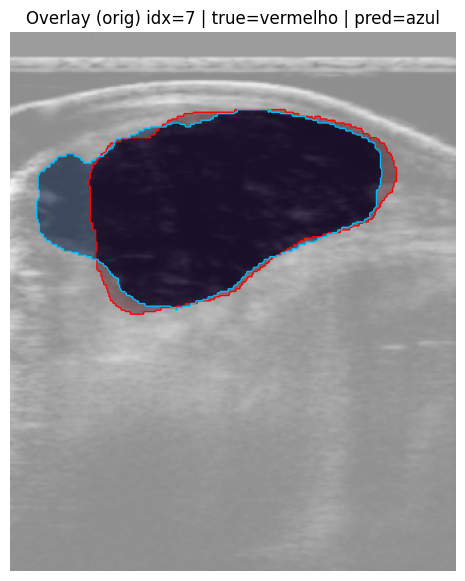

idx=8 | area_true=42.078 cm² | area_pred=44.175 cm² | diff=+2.097 cm² | dice=0.9186 | iou=0.8494


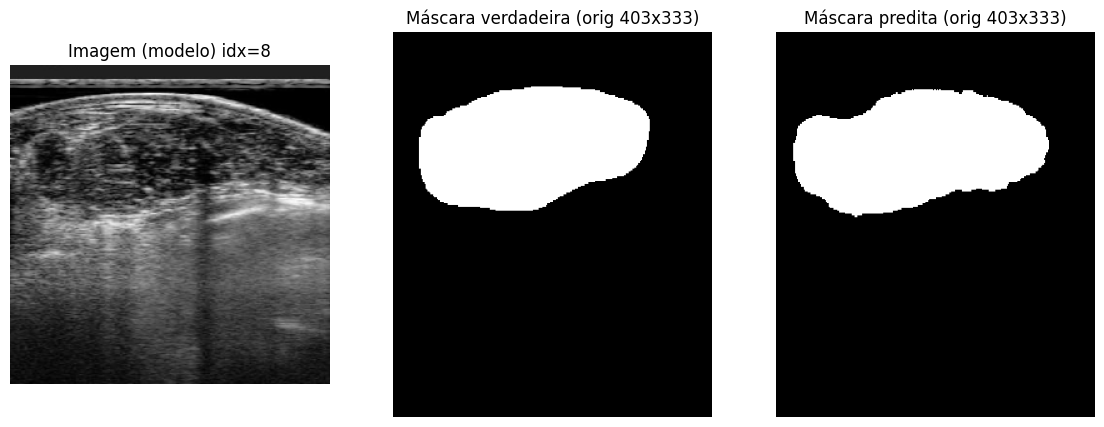

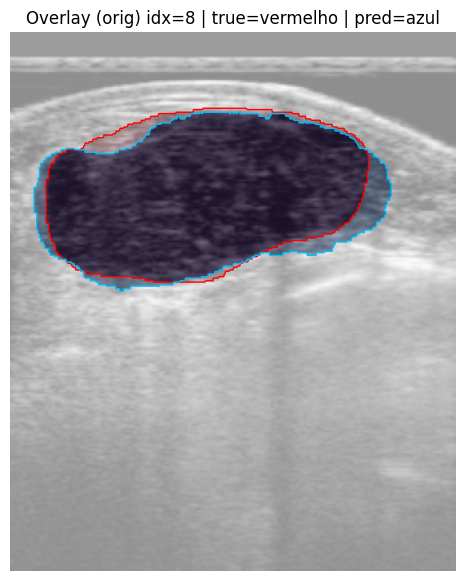

In [26]:
# Print função
for idx in range(len(x_new)):
    comparar_area_predicao(
        idx,
        modelo,
        x_new,
        y_new,
        nomes_dados= None,
        orig_size=(403, 333),
        threshold=0.5,
        px_per_cm=24.05,
        smooth=1e-6,
        plot=True,
        overlay_alpha=0.35,
        contours=True,
        verbose=True,
    )

In [ ]:
erros2 = []
for idx in range(len(x_new)):
    resultado2 = comparar_area_predicao(
        idx,
        modelo,
        x_new,
        y_new,
        nomes_dados=None,
        orig_size=(403, 333),
        threshold=0.5,
        px_per_cm=24.05,
        smooth=1e-6,
        plot=False,
        overlay_alpha=0.35,
        contours=True,
        verbose=False,
    )
    erros2.append(resultado2['diff_cm2'])

# Print dos erros
print(f'Erro médio nas novas imagens: {np.mean(np.abs(erros2)):.3f} cm²')
print(f'Erro Máximo nas novas imagens: {np.max(np.abs(erros2)):.3f} cm²')
print(f'Erro mínimo nas novas imagens: {np.min(np.abs(erros2)):.3f} cm²')

##  Calculando o R^2 

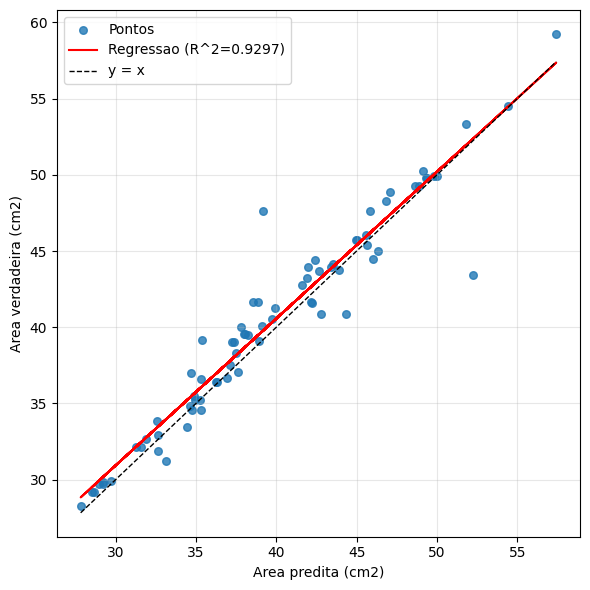

In [ ]:
y_pred = np.array(area_predita)
y_true = np.array(area_real)

# Ajuste de reta (y = a*x + b)
a, b = np.polyfit(y_pred, y_true, 1)
y_hat = a * y_pred + b

# R^2
y_mean = y_true.mean()
ss_tot = np.sum((y_true - y_mean) ** 2)
ss_res = np.sum((y_true - y_hat) ** 2)
r2 = 1.0 - (ss_res / ss_tot) if ss_tot != 0 else 0.0

plt.figure(figsize=(6, 6))
plt.scatter(y_pred, y_true, s=30, alpha=0.8, label="Pontos")
plt.plot(y_pred, y_hat, "r-", label=f"Regressao (R^2={r2:.4f})")
plt.plot([y_pred.min(), y_pred.max()],
         [y_pred.min(), y_pred.max()],
         "k--", linewidth=1, label="y = x")

plt.xlabel("Area predita (cm2)")
plt.ylabel("Area verdadeira (cm2)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Erro médio nas novas imagens: 3.728 cm²
Erro Máximo nas novas imagens: 9.784 cm²
Erro mínimo nas novas imagens: 0.213 cm²
